### 뇌 MRI 사진을 보고 뇌종양이 있는지 판별하기


 뇌종양이 있는 MRI 사진은 뇌가 비대칭적이며 종양 자리가 하얗게 덩어리로 보인다(Figure1 (a)). 그에 비해 뇌종양이 없는 MRI 사진은 뇌가 대칭적이며 하얀 덩어리가 보이지 않는다((Figure1 (b)). 오차역전파 알고리즘을 이용하여 이를 자동적으로 판별하였다.
 데이터로 kaggle에서 뇌종양이 있는 MRI 사진 1500장, 뇌종양이 없는 MRI 사진 1500장을 얻었다. (https://www.kaggle.com/abhranta/brain-tumor-detection-mri) 이 중, trainset으로 각각 1100장씩 총 2200장을 이용할 것이며(y0-y1099와 no0-1099), testset으로 400장씩 총 800장을 이용하였다(y1100-y1499와 no1100-1499). 각 사진 별로 사이즈가 모두 달라 이를 통일할 필요가 있었으며, 아직 라벨이 형성되어 있지 않기 때문에 라벨을 만드는 작업 역시 필요하였다. 

Figure1 (a) brain MRI with tumor, (b) brain MRI without tumor


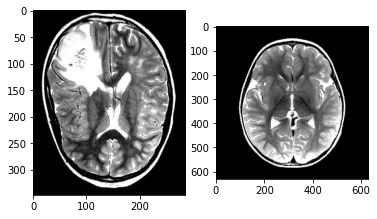

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2

sample_yes_tumor = cv2.imread('yes_tumor/y0.jpg')
sample_no_tumor = cv2.imread('no_tumor/no0.jpg')
plt.subplot(1,2,1)
plt.imshow(sample_yes_tumor)
plt.subplot(1,2,2)
plt.imshow(sample_no_tumor)
print('Figure1 (a) brain MRI with tumor, (b) brain MRI without tumor')

In [5]:
## backpropagation algorithm
# 수업시간의 교수님 코딩을 응용하여 4개의 은닉층인 형태로 만들어보았다.

def sigmoid(x):
    return 1./(1. + np.exp(-x))

# 은닉층이 4개인 신경망
def init_network(input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, output_dim):
    W1 = np.random.randn(input_dim, hidden1_dim)
    b1 = np.random.randn(hidden1_dim)
    W2 = np.random.randn(hidden1_dim, hidden2_dim)
    b2 = np.random.randn(hidden2_dim)
    W3 = np.random.randn(hidden2_dim, hidden3_dim)
    b3 = np.random.randn(hidden3_dim)
    W4 = np.random.randn(hidden3_dim, hidden4_dim)
    b4 = np.random.randn(hidden4_dim)
    W5 = np.random.randn(hidden4_dim, output_dim)
    b5 = np.random.randn(output_dim)
    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5

def forward(x, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5):
    z1 = sigmoid(np.matmul(x, W1) - b1)
    z2 = sigmoid(np.matmul(z1, W2) - b2)
    z3 = sigmoid(np.matmul(z2, W3) - b3)
    z4 = sigmoid(np.matmul(z3, W4) - b4)
    y = sigmoid(np.matmul(z4, W5) - b5)
    return z1, z2, z3, z4, y

def backward(x, ture_y, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, lr = 0.001):
    z1, z2, z3, z4, y = forward(x, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
    
    err_y = (true_y - y)*y*(1-y)
    err_z4 = err_y.dot(W5.T)*z4*(1-z4)
    err_z3 = err_z4.dot(W4.T)*z3*(1-z3)
    err_z2 = err_z3.dot(W3.T)*z2*(1-z2)
    err_z1 = err_z2.dot(W2.T)*z1*(1-z1)
    
    W5 = W5 + lr*np.matmul(z4.T, err_y)
    W4 = W4 + lr*np.matmul(z3.T, err_z4)
    W3 = W3 + lr*np.matmul(z2.T, err_z3)
    W2 = W2 + lr*np.matmul(z1.T, err_z2)
    W1 = W1 + lr*np.matmul(x.T, err_z1)
    
    b5 = b5 - lr * np.sum(err_y, axis = 0)
    b4 = b4 - lr * np.sum(err_z4, axis = 0)
    b3 = b3 - lr * np.sum(err_z3, axis = 0)
    b2 = b2 - lr * np.sum(err_z2, axis = 0)
    b1 = b1 - lr * np.sum(err_z1, axis = 0)
    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5

은닉층이 4개인 backpropagation algorithm을 완성하였다. 각 은닉층은 모두 시그모이드 함수를 이용하였다. 이 후, 사진들의 사이즈를 통일 시켜주고 라벨링을 하는 작업을 하였다. 이미지의 사이즈는 25 by 25으로 통일시켰으며, 어차피 MRI 사진은 컬러 사진이 아니기 때문에 흑백으로 전환하였다. 라벨링은 종양이 있는 경우가 [0, 1], 종양이 없는 경우가 [1, 0] 으로 one hot label을 이용하였다. 

In [39]:
## 이미지 사이즈 변경, 라벨링

train_img = []
train_label = []
test_img = []
test_label = []
test_original_img = []
for img_num in range(1500):
    yes_title = 'yes_tumor/y' + str(img_num) + '.jpg'
    no_title = 'no_tumor/no' + str(img_num) + '.jpg'
    yes_original_img = cv2.imread(yes_title)
    yes_original_img2 = cv2.cvtColor(yes_original_img, cv2.COLOR_BGR2GRAY) # 흑백사진으로 변환
    no_original_img = cv2.imread(no_title)
    no_original_img2 = cv2.cvtColor(no_original_img, cv2.COLOR_BGR2GRAY) # 흑백사진으로 변환
    yes_resize_img = cv2.resize(yes_original_img2, (25, 25)) # 이미지 크기 조정
    no_resize_img = cv2.resize(no_original_img2, (25, 25)) # 이미지 크기 조정
    
    if img_num < 1100:
        train_img.append(yes_resize_img)
        train_label.append([0.,1.])
        train_img.append(no_resize_img)
        train_label.append([1.,0.])
    else:
        test_img.append(yes_resize_img)
        test_label.append([0.,1.])
        test_original_img.append(yes_original_img)
        test_img.append(no_resize_img)
        test_label.append([1.,0.])
        test_original_img.append(no_original_img)

학습은 아래와 같이 진행하였다. 손실함수로는 sum_square_error을 사용하였다. batch의 크기는 150으로 하였으며, epoch은 40000번으로 하였다. 학습 진행 상황을 파악하기 위하여 2000 epoch마다 손실함수 값을 프린트해준다. learning rate는 0.001로 하는 것이 error가 진동하는 정도를 줄이면서 효율적으로 error를 줄여나갔다. 은닉층은 여러 시도를 해본 결과, 서서히 은닉층의 dimension을 줄여나가는 것이 학습 결과가 좋았기 때문에 첫번째 은닉층은 400, 두번째 은닉층은 200, 세번째 은닉층은 100, 네번째 은닉층은 50의 dimension을 갖게 하였다. 그 결과, 아래에 print 된 바와 같이 error가 감소하였다.

In [78]:
# 손실 함수로 sum of squares for error 이용
def sum_squares_error(y, true_y):
    return 0.5 * np.sum((y-true_y)**2)

# 학습
batch_size = 150
epoch_num = 40000

input_dim = 625
hidden1_dim = 400
hidden2_dim = 200
hidden3_dim = 100
hidden4_dim = 50
output_dim = 2

W1, b1, W2, b2, W3, b3, W4, b4, W5, b5\
= init_network(input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, output_dim)

epochs = []
train_errors = []
weights = []
for epoch in range(epoch_num):
    epochs.append(epoch)
    
    start = np.random.randint(len(train_img) - batch_size)
    
    x0 = train_img[start : start+batch_size]
    x = []
    for img in range(batch_size):
        x.append(np.reshape(x0[img], input_dim))
    x = np.array(x)
    true_y = np.array(train_label[start : start+batch_size])

    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = backward(x, true_y, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, lr = 0.001)
    z1, z2, z3, z4, y = forward(x, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
    train_error = sum_squares_error(y, true_y)
    train_errors.append(train_error)
    weight = W1, b1, W2, b2, W3, b3, W4, b4, W5, b5
    weights.append(weight)
    
    if epoch % 2000 == 0:
        print('epoch: ' + str(epoch) + ', error: ' + str(train_error))

/opt/anaconda-3-2020.02/envs/snu36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


epoch: 0, error: 65.60989533439133
epoch: 2000, error: 13.414950254272433
epoch: 4000, error: 9.798394867493862
epoch: 6000, error: 2.6637104346339444
epoch: 8000, error: 2.9583521202435463
epoch: 10000, error: 0.6942692783307718
epoch: 12000, error: 2.72349183375916
epoch: 14000, error: 2.4420197505027845
epoch: 16000, error: 2.251210123069338
epoch: 18000, error: 1.1454374876886788
epoch: 20000, error: 0.10611537329301403
epoch: 22000, error: 0.15746481470423515
epoch: 24000, error: 0.0996116722374718
epoch: 26000, error: 0.07355677759759427
epoch: 28000, error: 0.06345404961965884
epoch: 30000, error: 0.07486838427547127
epoch: 32000, error: 0.06309954641470278
epoch: 34000, error: 1.0393125842965558
epoch: 36000, error: 1.0416761038348665
epoch: 38000, error: 0.03772376202457628


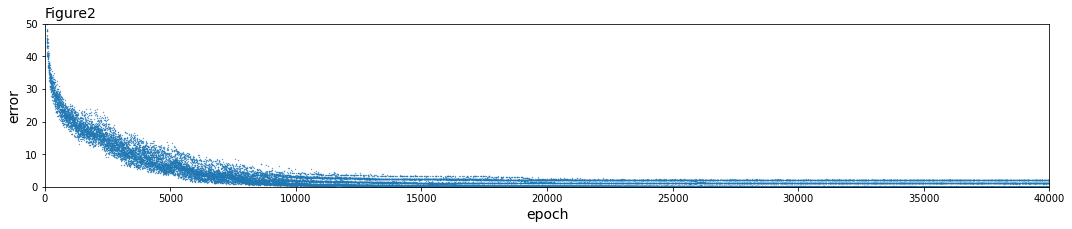

In [87]:
plt.figure(figsize = (18,3))
ax = plt.gca()
ax.set_facecolor('w')
plt.scatter(epochs, train_errors, s = 0.1)
plt.xlabel('epoch', fontsize = 14)
plt.ylabel('error', fontsize = 14)
plt.xlim(0, epoch_num)
plt.ylim(0, 50)
plt.title('Figure2', fontsize = 14, loc = 'left')
plt.show()

위에서 학습한 내용을 이제 testset에 직접 적용하여 MRI 사진상에 뇌종양이 있는지 없는지를 예측해보도록 하겠다. 가장 마지막 학습 기록을 가지고 예측하였다. 그 결과 약 84%의 정답율을 얻을 수 있었다. 아래의 Figure3 (a)~(d)는 랜덤으로 testset의 예측과 실제를 비교하여 보여준 것이다. 1이면 tumor가 있는 것이고, 0이면 tumor가 없는 것이다.
brain tumor의 존재 유무 판단이 환자의 생명과 직결된다는 점을 생각하였을 때 위의 정답율은 여전히 부족하다. Figure2의 error 변화의 추이를 보았을 때 여기서 epoch의 수를 늘리는 것은 더이상 의미가 없고 overfitting만 만들 것이다. 정답율을 더 높이기 위하여 CNN 모델을 사용하고 train set의 양을 더 늘려야 한다. Data augmentation은 기존 train set에서 블러 처리, 노이즈 처리, 상하좌우 변환 등을 하여 데이터의 수를 늘리는 방법인데, Data augmentation을 활용하면 효율적으로 train set을 늘릴 수 있을 것이다. 또한, brain MRI 사진에서 tumor 부분만 따로 도려내어 정상인 뇌에 합성하는 방식으로 마치 tumor가 있는 뇌인 것처럼 만들어 train set을 늘릴 수도 있을 것이라 기대한다.

In [88]:
## testset에 적용

x0_test = test_img
x_test = []
weight = weights[-1]

for img in range(len(test_img)):
    x_test.append(np.reshape(x0_test[img], input_dim))
x_test = np.array(x_test)
z1, z2, z3, z4, y_test\
= forward(x_test, weight[0], weight[1], weight[2], weight[3], weight[4], weight[5], weight[6], weight[7], weight[8], weight[9])
label_pred = np.argmax(y_test, axis = 1)
label_answer = np.argmax(test_label, axis = 1)
correct_num = 0
for img in range(len(test_img)):
    if label_pred[img] == label_answer[img]:
        correct_num += 1
score = correct_num / len(test_img)
print('accuracy: ' + str(score))

accuracy: 0.83875


/opt/anaconda-3-2020.02/envs/snu36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


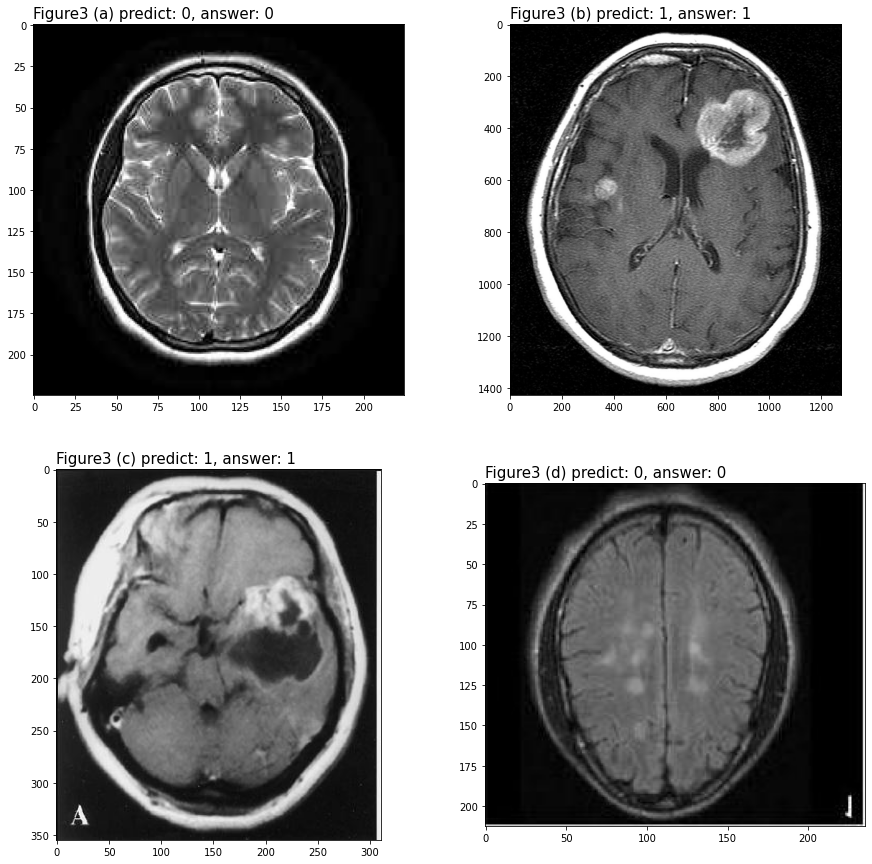

In [92]:
sample_img1_idx = np.random.randint(len(test_img))
sample_img1 = test_original_img[sample_img1_idx]
sample_label_pred1 = label_pred[sample_img1_idx]
sample_label_answer1 = label_answer[sample_img1_idx]

sample_img2_idx = np.random.randint(len(test_img))
sample_img2 = test_original_img[sample_img2_idx]
sample_label_pred2 = label_pred[sample_img2_idx]
sample_label_answer2 = label_answer[sample_img2_idx]

sample_img3_idx = np.random.randint(len(test_img))
sample_img3 = test_original_img[sample_img3_idx]
sample_label_pred3 = label_pred[sample_img3_idx]
sample_label_answer3 = label_answer[sample_img3_idx]

sample_img4_idx = np.random.randint(len(test_img))
sample_img4 = test_original_img[sample_img4_idx]
sample_label_pred4 = label_pred[sample_img4_idx]
sample_label_answer4 = label_answer[sample_img4_idx]

figure = plt.figure(figsize = (15, 15))
plt.subplot(2, 2, 1)
plt.imshow(sample_img1)
title1 = 'Figure3 (a) predict: ' + str(sample_label_pred1) + ', answer: ' + str(sample_label_answer1)
plt.title(title1, loc = 'left', fontsize = 15)

plt.subplot(2, 2, 2)
plt.imshow(sample_img2)
title2 = 'Figure3 (b) predict: ' + str(sample_label_pred2) + ', answer: ' + str(sample_label_answer2)
plt.title(title2, loc = 'left', fontsize = 15)

plt.subplot(2, 2, 3)
plt.imshow(sample_img3)
title3 = 'Figure3 (c) predict: ' + str(sample_label_pred3) + ', answer: ' + str(sample_label_answer3)
plt.title(title3, loc = 'left', fontsize = 15)

plt.subplot(2, 2, 4)
plt.imshow(sample_img4)
title4 = 'Figure3 (d) predict: ' + str(sample_label_pred4) + ', answer: ' + str(sample_label_answer4)
plt.title(title4, loc = 'left', fontsize = 15)
plt.show()